## SSAC - Exploration 6 - Lyricist

---

In [1]:
# import required packages
import re, glob, os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

## load data

In [2]:
txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []

# open the files in the directory and forge into raw_corpus object
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)

print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:3])

데이터 크기: 187088
Examples:
 ['', '', 'All of this and more is for you']


In [3]:
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue   # exclude read empty 'sentence'

    if idx > 15: break   # code check ; check if code works as intended with first 15 read 'sentence'
        
    print(sentence)

All of this and more is for you
With love, sincerity and deepest care
My life with you I share
Ever since I met you, baby
I've been wantin' to lay you down
But it's so hard to get you
Baby, when you never come around
Every day that you keep it away
It only makes me want it more
Ooh baby, just say the word
And I'll be at your door


## preprocess

In [4]:
sample = []
for idx, sentence in enumerate(raw_corpus):
    if len(sentence) == 0: continue
    print(type(sentence))
    sample.append(sentence)
    if idx > 10: break

<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>
<class 'str'>


In [5]:
sample

['All of this and more is for you',
 'With love, sincerity and deepest care',
 'My life with you I share',
 'Ever since I met you, baby',
 "I've been wantin' to lay you down",
 "But it's so hard to get you",
 'Baby, when you never come around',
 'Every day that you keep it away']

In [6]:
sample[1].split()

['With', 'love,', 'sincerity', 'and', 'deepest', 'care']

In [7]:
len(sample[1].split())

6

In [8]:
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()       # turn into small letters and erase empty space at each end.
  
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence)        # add one space before and after listed symbols
    sentence = re.sub(r'[" "]+', " ", sentence)               
    sentence = re.sub(r"[^a-zA-Z?.!]+", " ", sentence)        # take only alphabets and ? . ! as data

    sentence = sentence.strip()

    sentence = '<start> ' + sentence + ' <end>'      
    
    return sentence

print(preprocess_sentence("This @_is ;;;sample        sentence."))   # see if defined function works as intened with sample sentence

<start> this is sample sentence . <end>


In [9]:
for idx, sentence in enumerate(raw_corpus):
    print(len(sentence.split()))
    if idx > 5: break

0
0
8
6
6
0
0


In [10]:
# gather sentences minding that <start> or <end> would be cutted out from sentences. ; want to make 15 long sentence for input and target.
corpus = []

for sentence in raw_corpus:
    if len(sentence) == 0: continue
    
    sentence = preprocess_sentence(sentence)
    
    if len(sentence.split()) > 16: continue

    corpus.append(sentence)
        
corpus[0:10]

['<start> all of this and more is for you <end>',
 '<start> with love sincerity and deepest care <end>',
 '<start> my life with you i share <end>',
 '<start> ever since i met you baby <end>',
 '<start> i ve been wantin to lay you down <end>',
 '<start> but it s so hard to get you <end>',
 '<start> baby when you never come around <end>',
 '<start> every day that you keep it away <end>',
 '<start> it only makes me want it more <end>',
 '<start> ooh baby just say the word <end>']

In [11]:
len(corpus)

163436

In [12]:
len(corpus)*0.8

130748.8

In [13]:
over = 0
overlist = []
for idx, sentence in enumerate(corpus):
    if len(sentence.split()) > 14:
        over += 1
        overlist.append(idx)
print(over)

8887


In [14]:
print(corpus[overlist[0]])

<start> how will i take it when you call my name ? hey lover <end>


In [15]:
corpus[0].split()[:-1]

['<start>', 'all', 'of', 'this', 'and', 'more', 'is', 'for', 'you']

In [16]:
corpus[0].split()[1:]

['all', 'of', 'this', 'and', 'more', 'is', 'for', 'you', '<end>']

In [17]:
def tokenize(corpus):
    
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words = 15000,  # number of words to tokenize 
        filters = ' ',    
        oov_token = "<unk>"  # out-of-vocabulary
    )
    tokenizer.fit_on_texts(corpus)   
    
    # take out <end> and <start> from input and target corpus respectively
    input_corpus = []
    target_corpus =[]
    for sentence in corpus:
        input_corpus.append(sentence.split()[:-1])
        target_corpus.append(sentence.split()[1:])

    # turn corpus into tensor
    input_tensor = tokenizer.texts_to_sequences(input_corpus)   
    target_tensor = tokenizer.texts_to_sequences(target_corpus)
    
    # pre padding tensors
    input_tensor = tf.keras.preprocessing.sequence.pad_sequences(input_tensor, padding='pre')
    target_tensor = tf.keras.preprocessing.sequence.pad_sequences(target_tensor, padding='pre')

    print('input_tensor: ',input_tensor, 'target_tensor: ',target_tensor, 'tokenizer: ',tokenizer)
    return input_tensor, target_tensor, tokenizer

In [18]:
input_tensor, target_tensor, tokenizer = tokenize(corpus)

input_tensor:  [[    0     0     0 ...    25    27     6]
 [    0     0     0 ...     7  4667   287]
 [    0     0     0 ...     6     4  1012]
 ...
 [    0     0     0 ... 12811    25  3351]
 [    0     0     0 ...   323   583   799]
 [    0     0     0 ...  5016  2535   212]] target_tensor:  [[   0    0    0 ...   27    6    3]
 [   0    0    0 ... 4667  287    3]
 [   0    0    0 ...    4 1012    3]
 ...
 [   0    0    0 ...   25 3351    3]
 [   0    0    0 ...  583  799    3]
 [   0    0    0 ... 2535  212    3]] tokenizer:  <keras_preprocessing.text.Tokenizer object at 0x7fbcd72f7090>


In [37]:
del corpus

In [38]:
len(input_tensor) == len(target_tensor)

True

In [19]:
input_tensor[0]

array([ 0,  0,  0,  0,  0,  0,  2, 24, 18, 41,  7, 97, 25, 27,  6],
      dtype=int32)

In [20]:
len(input_tensor[0])

15

In [21]:
for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : the
6 : you
7 : and
8 : a
9 : to
10 : it


In [22]:
input_tensor[0]

array([ 0,  0,  0,  0,  0,  0,  2, 24, 18, 41,  7, 97, 25, 27,  6],
      dtype=int32)

In [23]:
target_tensor[0]

array([ 0,  0,  0,  0,  0,  0, 24, 18, 41,  7, 97, 25, 27,  6,  3],
      dtype=int32)

## data split

In [45]:
enc_train, enc_val, dec_train, dec_val = train_test_split(input_tensor,
                                                         target_tensor,
                                                         test_size=0.2,
                                                         random_state=7,
                                                         shuffle=True)

In [46]:
len(enc_train)

130748

In [47]:
del input_tensor

In [48]:
del target_tensor

In [49]:
BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

VOCAB_SIZE = tokenizer.num_words + 1    

In [50]:
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.repeat()
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(batch_size=BATCH_SIZE)
dataset

<BatchDataset shapes: ((None, 15), (None, 15)), types: (tf.int32, tf.int32)>

In [51]:
steps_per_epoch_val = len(enc_val) // BATCH_SIZE

In [52]:
# for test
val_dataset = tf.data.Dataset.from_tensor_slices((enc_val, dec_val)).shuffle(len(enc_val))
val_dataset = val_dataset.batch(batch_size=BATCH_SIZE) 
val_dataset

<BatchDataset shapes: ((None, 15), (None, 15)), types: (tf.int32, tf.int32)>

## build model

In [53]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [54]:
embedding_size = 128
hidden_size = 512
max_epochs = 10
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [55]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 15, 15001), dtype=float32, numpy=
array([[[ 2.3895100e-04, -5.8678811e-06,  7.2435898e-07, ...,
         -1.5747386e-05, -7.1886010e-05,  4.8947040e-05],
        [ 5.9751287e-04, -1.5470872e-05,  2.0694858e-06, ...,
         -5.1356881e-05, -1.6992235e-04,  8.7539927e-05],
        [ 9.9801051e-04, -2.8536992e-05,  4.4926355e-06, ...,
         -1.0578890e-04, -2.7060238e-04,  9.3844123e-05],
        ...,
        [ 1.3572025e-03, -8.8977913e-04,  2.2575684e-04, ...,
         -6.8792136e-04, -6.0292368e-04, -2.4548409e-04],
        [ 1.0253850e-03, -8.8640093e-04,  3.5719035e-04, ...,
         -8.0135232e-04, -6.0029590e-04, -2.7708957e-04],
        [ 7.6447020e-04, -7.4806396e-04,  4.0086376e-04, ...,
         -1.1433489e-03, -7.6101604e-04, -2.5852094e-04]],

       [[ 2.3895100e-04, -5.8678811e-06,  7.2435898e-07, ...,
         -1.5747386e-05, -7.1886010e-05,  4.8947040e-05],
        [ 5.9751287e-04, -1.5470872e-05,  2.0694858e-06, ...,
         -5.1356881e-05, 

In [56]:
model.summary()

Model: "text_generator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        multiple                  1920128   
_________________________________________________________________
lstm (LSTM)                  multiple                  1312768   
_________________________________________________________________
lstm_1 (LSTM)                multiple                  2099200   
_________________________________________________________________
dense (Dense)                multiple                  7695513   
Total params: 13,027,609
Trainable params: 13,027,609
Non-trainable params: 0
_________________________________________________________________


In [57]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/lyricist//models/e6_lyricist'

checkpoint_dir

'/home/ssac7/aiffel/lyricist//models/e6_lyricist'

In [58]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [59]:
# callback to save weights with lowest validation loss
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

## train model

In [60]:
history_text_gen = model.fit(dataset, epochs=max_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=steps_per_epoch_val,
                    callbacks=[cp_callback]
                    )

Epoch 1/10
510/510 [==============================] - ETA: 0s - loss: 3.7128 - accuracy: 0.5041
Epoch 00001: val_loss improved from inf to 3.26670, saving model to /home/ssac7/aiffel/lyricist//models/e6_lyricist
510/510 [==============================] - 50s 98ms/step - loss: 3.7128 - accuracy: 0.5041 - val_loss: 3.2667 - val_accuracy: 0.5262
Epoch 2/10
510/510 [==============================] - ETA: 0s - loss: 3.1442 - accuracy: 0.5372
Epoch 00002: val_loss improved from 3.26670 to 3.04867, saving model to /home/ssac7/aiffel/lyricist//models/e6_lyricist
510/510 [==============================] - 50s 98ms/step - loss: 3.1442 - accuracy: 0.5372 - val_loss: 3.0487 - val_accuracy: 0.5428
Epoch 3/10
510/510 [==============================] - ETA: 0s - loss: 2.9982 - accuracy: 0.5477
Epoch 00003: val_loss improved from 3.04867 to 2.97534, saving model to /home/ssac7/aiffel/lyricist//models/e6_lyricist
510/510 [==============================] - 50s 99ms/step - loss: 2.9982 - accuracy: 0.5477

+ validation loss is not low enough to pass the criteria

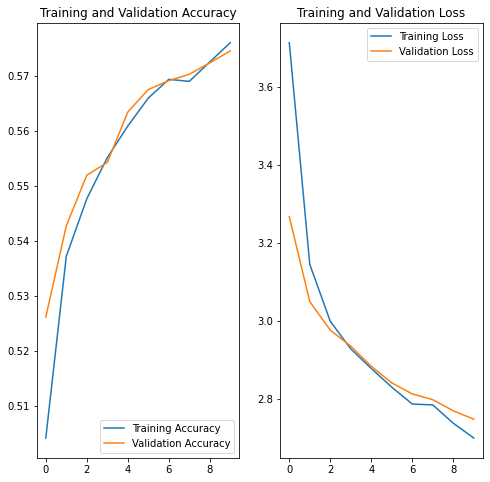

In [62]:
# trainig porgress plot
acc = history_text_gen.history['accuracy']
val_acc = history_text_gen.history['val_accuracy']

loss=history_text_gen.history['loss']
val_loss=history_text_gen.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [63]:
# evalueate model with test dataset
model.load_weights(checkpoint_dir)

In [64]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):

    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]


    while True:
        predict = model(test_tensor)  
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1]   


        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)


        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""

    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated   

In [65]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love you i m a one and i m a new <unk> . <end> '

+ model gives out grammatically wrong sentence

## build bigger model

In [67]:
del model

In [68]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super(TextGenerator, self).__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [69]:
embedding_size = 512
hidden_size = 1024
max_epochs = 15
model = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

In [70]:
for src_sample, tgt_sample in dataset.take(1): break
model(src_sample)

<tf.Tensor: shape=(256, 15, 15001), dtype=float32, numpy=
array([[[ 1.9743860e-04, -1.9847766e-04, -2.8271289e-04, ...,
         -2.5309520e-04, -7.5392301e-05,  1.0893109e-04],
        [ 4.5703517e-04, -5.2317290e-04, -7.4507232e-04, ...,
         -6.4470409e-04, -1.5079849e-04,  3.0269125e-04],
        [ 7.0696417e-04, -9.1117225e-04, -1.2953765e-03, ...,
         -1.0918957e-03, -2.0136852e-04,  5.6640262e-04],
        ...,
        [ 9.8324555e-04, -1.6773064e-03, -3.3152017e-03, ...,
         -1.9593958e-03, -2.3527681e-04,  4.3570492e-03],
        [ 1.2782532e-04, -1.2265858e-03, -2.6894293e-03, ...,
         -1.2533877e-03, -4.3917057e-04,  4.1912473e-03],
        [-8.5850235e-04, -9.4463816e-04, -2.1965390e-03, ...,
         -7.6937367e-04, -5.1443401e-04,  3.6542804e-03]],

       [[ 1.9743860e-04, -1.9847766e-04, -2.8271289e-04, ...,
         -2.5309520e-04, -7.5392301e-05,  1.0893109e-04],
        [ 4.5703517e-04, -5.2317290e-04, -7.4507232e-04, ...,
         -6.4470409e-04, 

In [71]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])

In [72]:
# the save point
checkpoint_dir = os.getenv('HOME')+'/aiffel/lyricist//models/e6_lyricist_big'

checkpoint_dir

'/home/ssac7/aiffel/lyricist//models/e6_lyricist_big'

In [74]:
# callback to save weights with lowest validation loss
cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_dir,
                                                 save_weights_only=True,
                                                 monitor='val_loss',
                                                 mode='auto',
                                                 save_best_only=True,
                                                 verbose=1)

## train bigger model

In [75]:
history_text_gen = model.fit(dataset, epochs=max_epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=val_dataset,
                    validation_steps=steps_per_epoch_val,
                    callbacks=[cp_callback]
                    )

Epoch 1/15
510/510 [==============================] - ETA: 0s - loss: 3.3458 - accuracy: 0.5278
Epoch 00001: val_loss improved from inf to 2.97546, saving model to /home/ssac7/aiffel/lyricist//models/e6_lyricist_big
510/510 [==============================] - 101s 197ms/step - loss: 3.3458 - accuracy: 0.5278 - val_loss: 2.9755 - val_accuracy: 0.5520
Epoch 2/15
510/510 [==============================] - ETA: 0s - loss: 2.8549 - accuracy: 0.5609
Epoch 00002: val_loss did not improve from 2.97546
510/510 [==============================] - 100s 195ms/step - loss: 2.8549 - accuracy: 0.5609 - val_loss: 2.9850 - val_accuracy: 0.5522
Epoch 3/15
510/510 [==============================] - ETA: 0s - loss: 2.7405 - accuracy: 0.5683
Epoch 00003: val_loss improved from 2.97546 to 2.69213, saving model to /home/ssac7/aiffel/lyricist//models/e6_lyricist_big
510/510 [==============================] - 101s 198ms/step - loss: 2.7405 - accuracy: 0.5683 - val_loss: 2.6921 - val_accuracy: 0.5741
Epoch 4/15
5

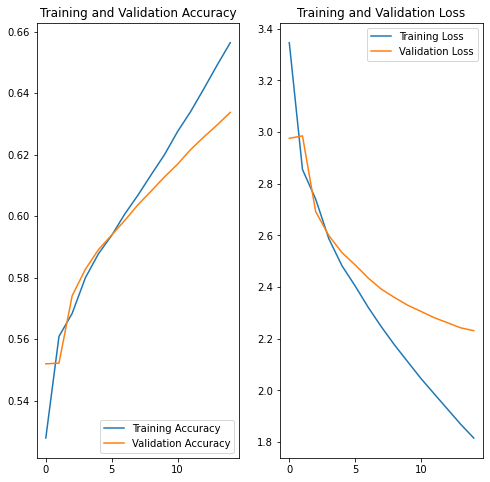

In [76]:
# trainig porgress plot
acc = history_text_gen.history['accuracy']
val_acc = history_text_gen.history['val_accuracy']

loss=history_text_gen.history['loss']
val_loss=history_text_gen.history['val_loss']

epochs_range = range(len(acc))

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [77]:
# evalueate model with test dataset
model.load_weights(checkpoint_dir)

In [78]:
generate_text(model, tokenizer, init_sentence="<start> i love")

'<start> i love the way you lie to you i m gonna marry the night <end> '

+ result sentence is not my type but makes sense